In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
# from livecellx import segment
from livecellx import core
from livecellx.core import datasets
from livecellx.core.datasets import LiveCellImageDataset, SingleImageDataset
from skimage import measure
from livecellx.core import SingleCellTrajectory, SingleCellStatic
# import detectron2
# from detectron2.utils.logger import setup_logger

# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
# from detectron2 import model_zoo
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog, DatasetCatalog
# from livecellx.segment.detectron_utils import gen_cfg

# from livecellx.segment.detectron_utils import (
#     segment_detectron_wrapper,
#     segment_images_by_detectron,
#     convert_detectron_instance_pred_masks_to_binary_masks,
#     convert_detectron_instances_to_label_masks,
# )
# from livecellx.segment.detectron_utils import (
#     convert_detectron_instance_pred_masks_to_binary_masks,
#     convert_detectron_instances_to_label_masks,
#     segment_images_by_detectron,
#     segment_single_img_by_detectron_wrapper,
# )


## Loading single cells from existing mask files

```LiveCellImageDataset, SingleCellImageDataset``` from livecellx.core.datasets allow users to load images with ease, without reading directly into memories.  
In `mask_dataset_path` please make sure that the sorted (alphabetically) file names correspond to the order of times.
 Note that the sorted mechanism provided is simply sort the url (file name) list according to string value. Please note that without proper left trailing zeroes, the order of final times may be incorrect. E.g. string  `T10` (10th file) is less than string `T2`. If you have your customized file patterns, please provide `LiveCellImageDataset` with a `time2url` dictionary to provide necessary time information mapped to file locations for reading time-lapsed data.
`SingleCellImageDataset` takes a single image from the memory and makes it a single time point dataset, which can be handy when you would like to process imaging datasets. 

In [2]:
# dataset_dir_path = Path(
#     "../datasets/test_data_STAV-A549/DIC_data"
# )

# mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")

dataset_dir_path = Path(
    "../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/"
)

mask_dataset_path = Path("../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg")

In [3]:
mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
mask_dataset.time2url

291 png img file paths loaded: 


{0: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T001_XY16_DIC.tif.png',
 1: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T002_XY16_DIC.tif.png',
 2: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T003_XY16_DIC.tif.png',
 3: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T004_XY16_DIC.tif.png',
 4: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg/seg_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T005_XY16_DIC.tif.png',
 5: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/o

In [4]:
time2url = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*_DIC.tif")))))
time2url = {i: path for i, path in enumerate(time2url)}
dic_dataset = LiveCellImageDataset(time2url=time2url, ext="tif")
# dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

Check if the `time2url` mapping is correct

In [5]:
dic_dataset.time2url

{0: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T001_XY16_DIC.tif',
 1: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T002_XY16_DIC.tif',
 2: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T003_XY16_DIC.tif',
 3: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T004_XY16_DIC.tif',
 4: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T005_XY16_DIC.tif',
 5: '../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T006_XY16_DIC.tif',
 6: 

In [6]:
max_time = 10
mask_dataset = mask_dataset.subset_by_time(0, max_time)
dic_dataset = dic_dataset.subset_by_time(0, max_time)

### Convert label masks to single objects

In [7]:
from skimage.measure import regionprops
from livecellx.segment.utils import prep_scs_from_mask_dataset
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


In [8]:
for sc in single_cells:
    assert sc.mask_dataset

In [9]:
# for testing
# single_cells = single_cells[:10]

In [10]:
len(single_cells)

190

In [11]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

### Visualize one single cell

<Axes: >

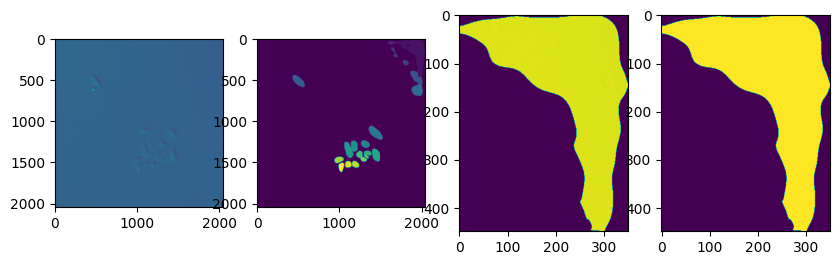

In [12]:
sc = single_cells[0]

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
sc.show(ax=axes[0])
sc.show_mask(ax=axes[1])
sc.show_contour_img(ax=axes[2])
sc.show_contour_mask(ax=axes[3])

array([<Axes: title={'center': 'img'}>, <Axes: title={'center': 'mask'}>,
       <Axes: title={'center': 'contour_img'}>,
       <Axes: title={'center': 'contour_mask'}>,
       <Axes: title={'center': 'mask_crop'}>], dtype=object)

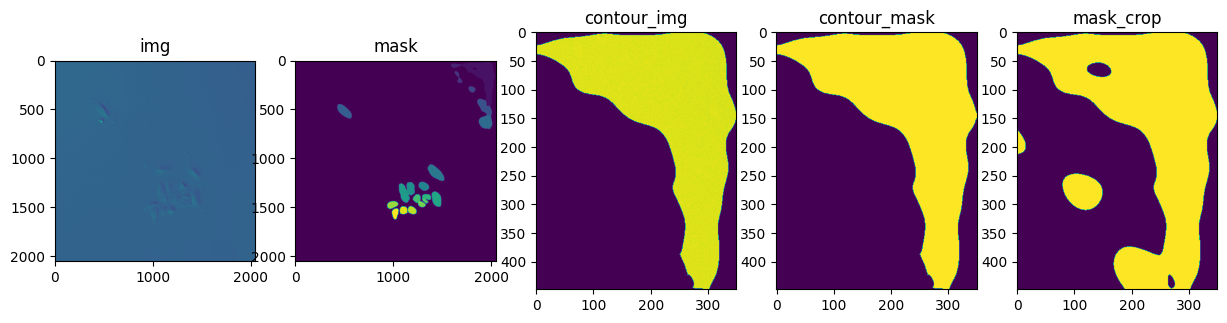

In [13]:
sc.show_panel(figsize=(15, 5))

In [14]:
sc1 = single_cells[1]
sc2 = single_cells[2]

In [15]:
from livecellx.trajectory.feature_extractors import compute_skimage_regionprops, compute_haralick_features

skimage_features = compute_skimage_regionprops(sc1)
sc1.add_feature("skimage", skimage_features)

In [16]:
# haralick_features = compute_haralick_features(sc1)
# sc1.add_feature("haralick", haralick_features)

In [17]:
sc1.get_feature_pd_series()

skimage_area                 3173.000000
skimage_area_bbox            4488.000000
skimage_area_convex          3311.000000
skimage_area_filled          3173.000000
skimage_axis_major_length     101.795961
                                ...     
skimage_orientation            -1.542148
skimage_perimeter             252.852814
skimage_perimeter_crofton     242.401016
skimage_solidity                0.958321
t                               0.000000
Length: 148, dtype: float64

Calculate overlap between two single cells

In [18]:
sc1.compute_iou(sc2), sc1.compute_overlap_percent(sc2)

(0.0, 0.0)

## Tracking based on single cells

In [19]:
from typing import List
from livecellx.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours,
    track_SORT_bbox_from_scs
)


traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, mask_dataset=mask_dataset, max_age=1, min_hits=1)

matching image path: ../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T001_XY16_DIC.tif
matching image path: ../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T002_XY16_DIC.tif
matching image path: ../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T003_XY16_DIC.tif
matching image path: ../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T004_XY16_DIC.tif
matching image path: ../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T005_XY16_DIC.tif
matching image path: ../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-1

generate movies

In [20]:
# from livecellx.track.movie import generate_single_trajectory_movie

# for track_id, traj in traj_collection:
#     generate_single_trajectory_movie(traj, save_path=f"./notebook_results/general_tutorial/track_movies/track_{track_id}.gif")

<Axes: ylabel='Count'>

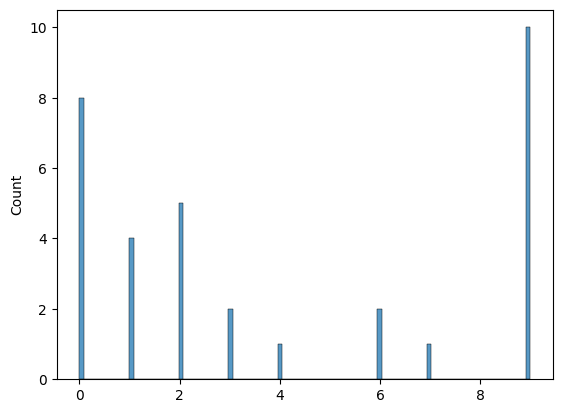

In [21]:
traj_collection.histogram_traj_length()

In [22]:
# for track_id, traj in traj_collection:
#     print("track_id=", track_id)
#     traj.timeframe_to_single_cell[list(traj.timeframe_to_single_cell.keys())[0]].show_panel(figsize=(20, 5))
#     plt.show()
    

In [23]:
%gui qt
from livecellx.core.napari_visualizer import NapariVisualizer
import napari
from skimage import data


In [24]:
for time in dic_dataset.times:
    assert time in dic_dataset.time2url
    assert dic_dataset.time2url[time] is not None
    # assert dic_dataset.read_img_url_func(dic_dataset.time2url[time]) is not None

In [25]:
# def to_dask(self, times=None, ram=False):
#     """convert to a dask array for napari visualization"""
#     import dask.array as da
#     from dask import delayed
#     if times is None:
#         times = self.times
#     if ram:
#         return da.stack([da.from_array(self.time2url[time]) for time in times])
    
#     lazy_reader = delayed(self.read_img_url_func)
#     lazy_arrays = [lazy_reader(self.time2url[time]) for time in times]
#     dask_arrays = [da.from_delayed(lazy_array, shape=(100, 100), dtype=int) for lazy_array in lazy_arrays]
#     return da.stack(dask_arrays)

# shape = dic_dataset.infer_shape()
# to_dask(dic_dataset)
# dic_dataset.to_dask = to_dask
# mask_dataset.to_dask = to_dask

In [26]:
from livecellx.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
import numpy as np
from napari.viewer import Viewer
from livecellx.core.visualizer import Visualizer

### Visualize with napari 

In [27]:
# viewer = napari.view_image(dic_dataset.to_dask(), name='dic_image', cache=True)
# shape_layer = NapariVisualizer.viz_trajectories(traj_collection, viewer, contour_sample_num=20)

### Create SCT Operator

In [28]:
from napari.layers import Shapes
from livecellx.core.single_cell import SingleCellTrajectoryCollection
from livecellx.core.sct_operator import SctOperator, create_sct_napari_ui


viewer = napari.view_image(dic_dataset.to_dask(), name="dic_image", cache=True)
shape_layer = NapariVisualizer.viz_trajectories(traj_collection, viewer, contour_sample_num=20)
sct_operator = SctOperator(traj_collection, shape_layer, viewer)
sct_operator.setup_shape_layer(shape_layer, viewer=viewer)

create_sct_napari_ui(sct_operator)

In [29]:
from livecellx.preprocess.utils import normalize_img_to_uint8

img = normalize_img_to_uint8(dic_dataset.get_img_by_time(2))
import PIL
# save img
PIL.Image.fromarray(img).save("img.png")

In [30]:
# sct_operator.update_shape_layer_by_track_id(6, face_color="blue", new_track_id=6)

In [31]:
# sct_operator.connect_two_scts()
# sct_operator.disconnect_sct()

In [32]:
# sct_operator.clear_selection()
# sct_operator.connect_two_scts()
# sct_operator.add_mother_daughter_relation()

In [33]:
event = object()
sct_operator.select_shape(event)

current shape layer shape properties:  <object object at 0x0000019CED8E6650>
No shape selected, please select a shape to connect trajectories


In [34]:
shape_layer.text

TextManager(string=FormatStringEncoding(fallback=array('', dtype='<U1'), format='id: {track_id}\n{status}', encoding_type='FormatStringEncoding'), color=ConstantColorEncoding(constant=array([1., 1., 1., 1.], dtype=float32), encoding_type='ConstantColorEncoding'), visible=True, size=12, blending=<Blending.TRANSLUCENT: 'translucent'>, anchor=<Anchor.CENTER: 'center'>, translation=array([-2.,  0.]), rotation=0.0)

In [35]:
sct_operator.select_info

[]

In [36]:
sct_operator.magicgui_container[2].hide()

In [ ]:
sct_operator.select_info

In [ ]:
# from qtpy.QtWidgets import QPushButton
# connect_btn = QPushButton('Connect two trajectories')
# connect_btn.resize(100, 100)
# connect_btn.clicked.connect(sct_operator.connect_two_scts)
# widget = viewer.window.add_dock_widget(connect_btn, name="edit trajectory")

# clear_btn = QPushButton('Clear selection')
# clear_btn.resize(100, 100)
# clear_btn.clicked.connect(sct_operator.clear_selection)
# viewer.window.add_dock_widget(clear_btn, name="edit trajectory")

In [ ]:
shape = shape_layer.data[0]

In [ ]:
# viewer.layers.selection.events.active.connect(lambda x: print(dir(x)))